In [1]:
import os
import ot
import json
import pprint
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import statsmodels.api as sm
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

from domain_adaptation.divergences import wasserstein_distance
from domain_adaptation.divergences import maximum_mean_discrepancy

from utils import cval_performance

import warnings
warnings.filterwarnings("ignore")

plt.style.use('science')

# For figure aesthetics
plt.rcParams['mathtext.fontset'] = 'custom'  
plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'  
plt.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'  
plt.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'  
plt.rcParams['font.size'] = 16
plt.rcParams['mathtext.fontset'] = 'stix'  
plt.rcParams['font.family'] = 'STIXGeneral' 

Using TensorFlow backend.


In [2]:
def feature_normalization(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    
    return (X - mean) / std

In [3]:
def feature_scaling(X):
    maxval = np.max(X, axis=0)
    minval = np.min(X, axis=0)
    
    return (X - minval) / (maxval - minval)

## Feature Distributions

In [38]:
df = pd.read_csv('./data/cstr_rawdata.csv')

data_mat = df.values
X = data_mat[:, :-4]
X = feature_scaling(X)
y = df['Class'].values
d = df['Domain'].values

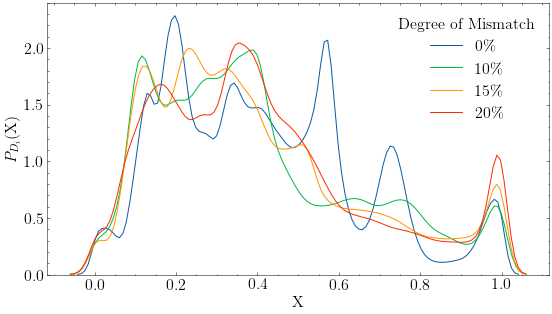

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))

sns.distplot(feature_scaling(X[np.where(d == 0)]).flatten(), hist=False, ax=ax, label='$0\%$')
sns.distplot(feature_scaling(X[np.where(d == 1)]).flatten(), hist=False, ax=ax, label='$10\%$')
sns.distplot(feature_scaling(X[np.where(d == 2)]).flatten(), hist=False, ax=ax, label='$15\%$')
sns.distplot(feature_scaling(X[np.where(d == 3)]).flatten(), hist=False, ax=ax, label='$20\%$')
ax.set_ylabel('$P_{D_{i}}$(X)')
ax.set_xlabel('X')
ax.legend(title='Degree of Mismatch')
plt.savefig('./Figures/Ch6/CSTR_CovariateShift.pdf')

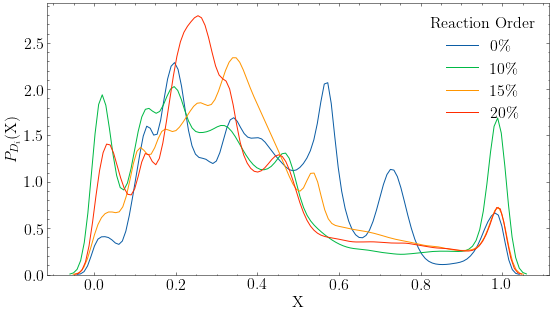

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))

sns.distplot(feature_scaling(X[np.where(d == 0)]).flatten(), hist=False, ax=ax, label='$0\%$')
sns.distplot(feature_scaling(X[np.where(d == 4)]).flatten(), hist=False, ax=ax, label='$10\%$')
sns.distplot(feature_scaling(X[np.where(d == 5)]).flatten(), hist=False, ax=ax, label='$15\%$')
sns.distplot(feature_scaling(X[np.where(d == 6)]).flatten(), hist=False, ax=ax, label='$20\%$')
ax.set_ylabel('$P_{D_{i}}$(X)')
ax.set_xlabel('X')
ax.legend(title='Reaction Order')
plt.savefig('./Figures/Ch6/CSTR_CovariateShift_ReactOrder.pdf')

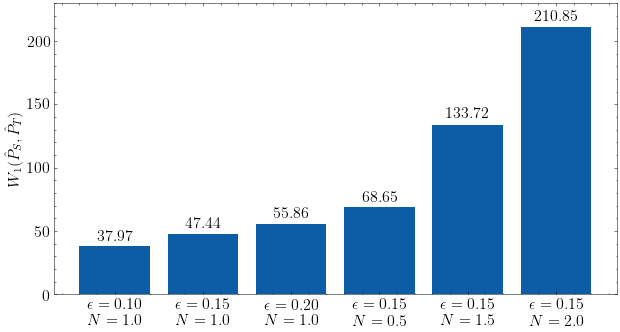

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))

barX = []
barY = []
for i, domain in enumerate(np.unique(d)[1:]):
    Xs = X[np.where(d == 0)[0]]
    Xt = X[np.where(d == domain)[0]]
    
    wdist = wasserstein_distance(Xs, Xt, norm=None, metric='cityblock')
    barX.append(i)
    barY.append(wdist)
    ax.text(i, wdist + 5, s="{}".format(np.round(wdist, 2)), ha='center')
    
ax.bar(barX, barY)
ax.set_xticklabels(['0',
                    r'$\epsilon=0.10$' + '\n' + r'$N = 1.0$',
                    r'$\epsilon=0.15$' + '\n' + r'$N = 1.0$',
                    r'$\epsilon=0.20$' + '\n' + r'$N = 1.0$',
                    r'$\epsilon=0.15$' + '\n' + r'$N = 0.5$',
                    r'$\epsilon=0.15$' + '\n' + r'$N = 1.5$',
                    r'$\epsilon=0.15$' + '\n' + r'$N = 2.0$'])
ax.set_ylabel(r'$W_{1}(\hat{P}_{S}, \hat{P}_{T})$')
ax.set_ylim([0, 230])
plt.tight_layout()

plt.savefig('./Figures/Ch6/Wdists_CSTR.pdf')

# Raw Features

In [5]:
df = pd.read_csv('./data/cstr_rawdata.csv')

data_mat = df.values
X = data_mat[:, :-4]
y = df['Class'].values
d = df['Domain'].values

Xs, ys = X[np.where(d == 0)[0]], y[np.where(d == 0)[0]]

dataset = np.load('./data/DistributionalShiftData/raw_cstr_distrshift.npy')

X = dataset[:, :-3]
y = dataset[:, -3]
E = dataset[:, -2]
N = dataset[:, -1]

targets_E = [
    (eps,
     X[np.intersect1d(np.where(E == eps)[0], np.where(N == 1))],
     y[np.intersect1d(np.where(E == eps)[0], np.where(N == 1))]) for eps in [i / 10 for i in range(1, 10)]
]

targets_N = [
    (Ni,
     X[np.intersect1d(np.where(E == 0.15)[0], np.where(N == Ni))],
     y[np.intersect1d(np.where(E == 0.15)[0], np.where(N == Ni))]) for Ni in [0.25, 0.5, 0.75, 1,
                                                                              1.25, 1.75, 2.0]
]

## Parameters vs. Distributional Shift

In [6]:
ErawX = []
ErawY = []
for eps, Xt, yt in targets_E:
    a = ot.unif(Xs.shape[0])
    b = ot.unif(Xt.shape[0])
    M = ot.dist(feature_normalization(Xs),
                feature_normalization(Xt), metric='sqeuclidean')
    # M /= np.max(M)
    G = ot.emd(a, b, M)
    
    ErawX.append(eps)
    ErawY.append(np.sum(M * G))

Text(0.5, 0, 'Degree of Parameter Mismatch')

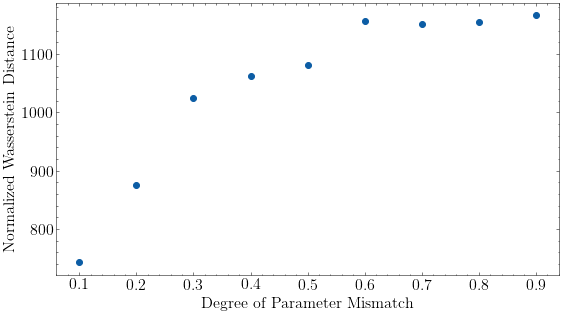

In [11]:
plt.figure(figsize=(9, 5))
plt.scatter(ErawX, ErawY)
plt.ylabel('Normalized Wasserstein Distance')
plt.xlabel('Degree of Parameter Mismatch')

In [47]:
NrawX = []
NrawY = []
for Ni, Xt, yt in targets_N:
    a = ot.unif(Xs.shape[0])
    b = ot.unif(Xt.shape[0])
    M = ot.dist(feature_normalization(Xs),
                feature_normalization(Xt),
                metric='sqeuclidean')
    # M /= np.max(M)
    G = ot.emd(a, b, M)
    
    NrawX.append(Ni)
    NrawY.append(np.sum(M * G))

Text(0.5, 0, 'Degree of Parameter Mismatch')

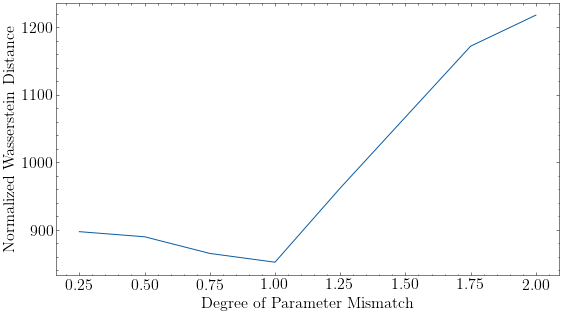

In [48]:
plt.figure(figsize=(9, 5))
plt.plot(NrawX, NrawY)
plt.ylabel('Normalized Wasserstein Distance')
plt.xlabel('Degree of Parameter Mismatch')

## Distributional Shift vs. Accuracy

In [49]:
def experiment_distributional_shift(clf, source, targets_E, targets_N):
    accs = []
    wdists = []
    Xs, ys = source
    for param, Xt, yt in targets_E + targets_N:
        """
        for _ in range(10):
            Xtr, _, ytr, _ = train_test_split(Xs, ys, train_size=0.8, stratify=ys)
            Xts, _, yts, _ = train_test_split(Xt, yt, train_size=0.8, stratify=yt)
            wdists.append(wasserstein_distance(Xtr, Xts, norm='max', metric='sqeuclidean'))
            Xtr = feature_normalization(Xtr)
            Xts = feature_normalization(Xts)
            clf.fit(Xtr, ytr)
            yp = clf.predict(Xts)
            acc = accuracy_score(yts, yp)
            accs.append(acc)
        """
        Xtr, ytr = feature_normalization(Xs), ys.copy()
        Xts, yts = feature_normalization(Xt), yt.copy()
        dist = wasserstein_distance(Xs, Xt, norm=None, metric='cityblock')
        wdists.append(dist)
        clf.fit(Xtr, ytr)
        yp = clf.predict(Xts)
        acc = accuracy_score(yts, yp)
        accs.append(acc)
        print(param, dist, acc)
    
    return wdists, 100 * np.array(accs)

In [50]:
clf1 = SVC(kernel='linear', max_iter=1e+6)
clf2 = SVC(kernel='rbf', max_iter=1e+6)
clf3 = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', max_iter=100)

In [51]:
print('Running tests on clf1')
raw_wdists, raw_accs1 = experiment_distributional_shift(clf1, (Xs, ys), targets_E, targets_N)
print('Running tests on clf2')
raw_wdists, raw_accs2 = experiment_distributional_shift(clf2, (Xs, ys), targets_E, targets_N)
print('Running tests on clf3')
raw_wdists, raw_accs3 = experiment_distributional_shift(clf3, (Xs, ys), targets_E, targets_N)

Running tests on clf1
0.1 4931.804809581749 0.6807692307692308
0.2 8184.923147889291 0.6269230769230769
0.3 11598.122117373005 0.4807692307692308
0.4 15673.44413984569 0.3769230769230769
0.5 20600.72956422537 0.3730769230769231
0.6 26517.495021037754 0.36538461538461536
0.7 27034.488037729378 0.35384615384615387
0.8 31512.149542249295 0.4269230769230769
0.9 31133.273899118056 0.3576923076923077
0.25 8725.98995197687 0.5961538461538461
0.5 8205.478909092752 0.6038461538461538
0.75 6988.6415612310075 0.6538461538461539
1 7079.707593469541 0.6307692307692307
1.25 12294.332783940732 0.49615384615384617
1.75 25894.489912568268 0.49230769230769234
2.0 30106.029781967158 0.4576923076923077
Running tests on clf2
0.1 4931.804809581749 0.7615384615384615
0.2 8184.923147889291 0.6384615384615384
0.3 11598.122117373005 0.5692307692307692
0.4 15673.44413984569 0.4346153846153846
0.5 20600.72956422537 0.40384615384615385
0.6 26517.495021037754 0.36538461538461536
0.7 27034.488037729378 0.30769230769

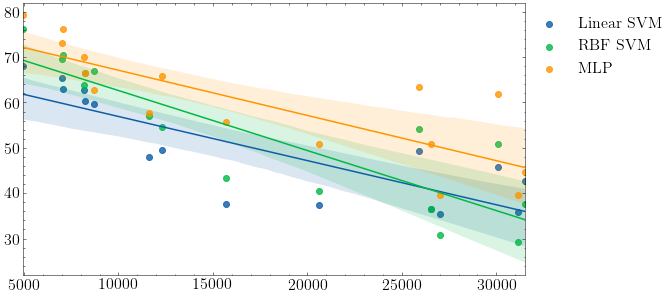

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
sns.regplot(raw_wdists, raw_accs1, label='Linear SVM')
sns.regplot(raw_wdists, raw_accs2, label='RBF SVM')
sns.regplot(raw_wdists, raw_accs3, label='MLP')
ax.legend(bbox_to_anchor=(1.3, 1))

# ACF Features

In [53]:
df = pd.read_csv('./data/cstr_acfmeandata.csv')

data_mat = df.values
X = data_mat[:, :-4]
y = df['Class'].values
d = df['Domain'].values

Xs, ys = X[np.where(d == 0)[0]], y[np.where(d == 0)[0]]
Xs = feature_normalization(Xs)
_X = X.copy()

dataset = np.load('./data/DistributionalShiftData/acfmean_cstr_distrshift.npy')

X = dataset[:, :-3]
y = dataset[:, -3]
E = dataset[:, -2]
N = dataset[:, -1]

targets_E = [
    (eps,
     X[np.intersect1d(np.where(E == eps)[0], np.where(N == 1))],
     y[np.intersect1d(np.where(E == eps)[0], np.where(N == 1))]) for eps in [i / 10 for i in range(1, 10)]
]

targets_N = [
    (Ni,
     X[np.intersect1d(np.where(E == 0.15)[0], np.where(N == Ni))],
     y[np.intersect1d(np.where(E == 0.15)[0], np.where(N == Ni))]) for Ni in [0.25, 0.5, 0.75, 1,
                                                                              1.25, 1.75, 2.0]
]

## Parameters vs. Distributional Shift

In [54]:
EacfX = []
EacfY = []
for eps, Xt, yt in targets_E:
    a = ot.unif(Xs.shape[0])
    b = ot.unif(Xt.shape[0])
    M = ot.dist(feature_normalization(Xs), feature_normalization(Xt), metric='sqeuclidean')
    #M /= np.max(M)
    G = ot.emd(a, b, M)
    
    EacfX.append(eps)
    EacfY.append(np.sum(M * G))

Text(0.5, 0, 'Degree of Parameter Mismatch')

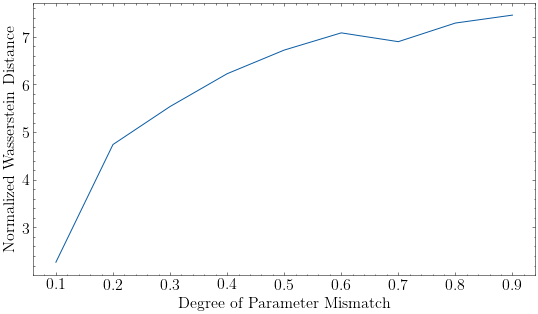

In [55]:
plt.figure(figsize=(9, 5))
plt.plot(EacfX, EacfY)
plt.ylabel('Normalized Wasserstein Distance')
plt.xlabel('Degree of Parameter Mismatch')

In [71]:
NacfX = []
NacfY = []
for Ni, Xt, yt in targets_N:
    a = ot.unif(Xs.shape[0])
    b = ot.unif(Xt.shape[0])
    M = ot.dist(feature_normalization(Xs), feature_normalization(Xt), metric='sqeuclidean')
    # M /= np.max(M)
    G = ot.emd(a, b, M)
    
    NacfX.append(Ni)
    NacfY.append(np.sum(M * G))

Text(0.5, 0, 'Reaction Order')

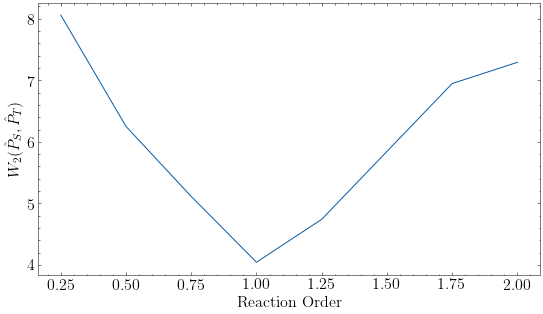

In [73]:
plt.figure(figsize=(9, 5))
plt.plot(NacfX, NacfY)
plt.ylabel(r'$W_{2}(\hat{P}_{S}, \hat{P}_{T})$')
plt.xlabel('Reaction Order')

## Distributional Shift vs. Accuracy

In [58]:
clf1 = SVC(kernel='linear', max_iter=1e+6)
clf2 = SVC(kernel='rbf', max_iter=1e+6)
clf3 = MLPClassifier(hidden_layer_sizes=(100,), activation='relu')

acf_wdists, acf_accs1 = experiment_distributional_shift(clf1, (Xs, ys), targets_E, targets_N)
acf_wdists, acf_accs2 = experiment_distributional_shift(clf2, (Xs, ys), targets_E, targets_N)
acf_wdists, acf_accs3 = experiment_distributional_shift(clf3, (Xs, ys), targets_E, targets_N)

0.1 8.672787581823561 0.9769230769230769
0.2 8.713346590766541 0.9153846153846154
0.3 8.72328374508022 0.8692307692307693
0.4 8.783536157062333 0.85
0.5 8.844044467849239 0.823076923076923
0.6 8.874321533044942 0.7923076923076923
0.7 8.87472415362701 0.8192307692307692
0.8 8.930312358054891 0.8153846153846154
0.9 8.919605476026543 0.8192307692307692
0.25 8.85423287909856 0.8730769230769231
0.5 8.797987500105778 0.95
0.75 8.761433374318864 0.9038461538461539
1 8.695358242319921 0.9230769230769231
1.25 8.761839191454655 0.8384615384615385
1.75 8.960368260744005 0.6115384615384616
2.0 8.9535100207038 0.6038461538461538
0.1 8.672787581823561 0.9692307692307692
0.2 8.713346590766541 0.8923076923076924
0.3 8.72328374508022 0.8615384615384616
0.4 8.783536157062333 0.8153846153846154
0.5 8.844044467849239 0.7884615384615384
0.6 8.874321533044942 0.7423076923076923
0.7 8.87472415362701 0.8076923076923077
0.8 8.930312358054891 0.7846153846153846
0.9 8.919605476026543 0.7961538461538461
0.25 8.85

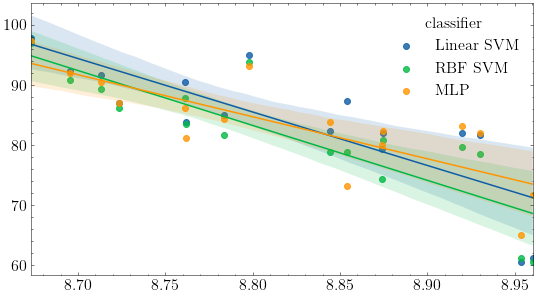

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
sns.regplot(acf_wdists, acf_accs1, label='Linear SVM')
sns.regplot(acf_wdists, acf_accs2, label='RBF SVM')
sns.regplot(acf_wdists, acf_accs3, label='MLP')
ax.legend(title='classifier', bbox_to_anchor=(1, 1))

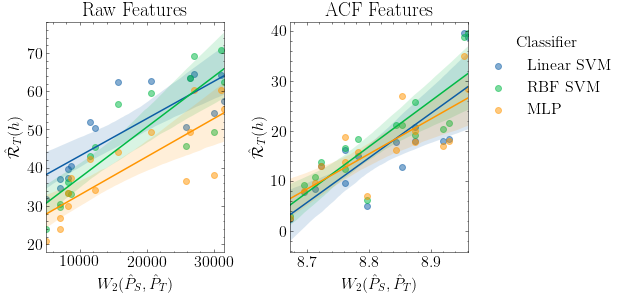

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4.5))

sns.regplot(raw_wdists, 100 - raw_accs1, label='Linear SVM', ax=axes[0], scatter_kws={'alpha':0.5})
sns.regplot(raw_wdists, 100 - raw_accs2, label='RBF SVM', ax=axes[0], scatter_kws={'alpha':0.5})
sns.regplot(raw_wdists, 100 - raw_accs3, label='MLP', ax=axes[0], scatter_kws={'alpha':0.5})
axes[0].set_xlabel('$W_{2}(\hat{P}_{S}, \hat{P}_{T})$')
axes[0].set_ylabel('$\hat{\mathcal{R}}_{T}(h)$')
axes[0].set_title('Raw Features')

sns.regplot(acf_wdists, 100 - acf_accs1, label='Linear SVM', ax=axes[1], scatter_kws={'alpha':0.5})
sns.regplot(acf_wdists, 100 - acf_accs2, label='RBF SVM', ax=axes[1], scatter_kws={'alpha':0.5})
sns.regplot(acf_wdists, 100 - acf_accs3, label='MLP', ax=axes[1], scatter_kws={'alpha':0.5})
axes[1].set_xlabel('$W_{2}(\hat{P}_{S}, \hat{P}_{T})$')
axes[1].set_ylabel('$\hat{\mathcal{R}}_{T}(h)$')
axes[1].legend(title='Classifier', bbox_to_anchor=(1, 1))
axes[1].set_title('ACF Features')

plt.tight_layout()
plt.savefig('./Figures/Ch6/DistrShiftAcc.pdf')

In [67]:
slope1, intercept, r_value, p_value, std_err = stats.linregress(acf_wdists, 100 - acf_accs1)
print('Regression Slope Linear SVM: {}'.format(slope1))
print('R2: {}, P: {}'.format(r_value, p_value))
slope2, intercept, r_value, p_value, std_err = stats.linregress(acf_wdists, 100 - acf_accs2)
print('Regression Slope RBF SVM: {}'.format(slope2))
print('R2: {}, P: {}'.format(r_value, p_value))
slope3, intercept, r_value, p_value, std_err = stats.linregress(acf_wdists, 100 - acf_accs3)
print('Regression Slope MLP: {}'.format(slope3))
print('R2: {}, P: {}'.format(r_value, p_value))

Regression Slope Linear SVM: 89.03398304619004
R2: 0.8109781401362708, P: 0.00013799255667780677
Regression Slope RBF SVM: 91.44990818257854
R2: 0.8527600493972288, P: 2.7008929447713143e-05
Regression Slope MLP: 70.01241432471605
R2: 0.7963023618608904, P: 0.00022336971472985902


In [84]:
slope1, intercept, r_value, p_value, std_err = stats.linregress(raw_wdists, 100 - raw_accs1)
print('Regression Slope Linear SVM: {}'.format(slope1 * 10 ** 4))
print('R2: {}, P: {}'.format(r_value, p_value))
slope2, intercept, r_value, p_value, std_err = stats.linregress(raw_wdists, 100 - raw_accs2)
print('Regression Slope RBF SVM: {}'.format(slope2 * 10 ** 4))
print('R2: {}, P: {}'.format(r_value, p_value))
slope3, intercept, r_value, p_value, std_err = stats.linregress(raw_wdists, 100 - raw_accs3)
print('Regression Slope MLP: {}'.format(slope3 * 10 ** 4))
print('R2: {}, P: {}'.format(r_value, p_value))

Regression Slope Linear SVM: 9.73236099597056
R2: 0.822152709058091, P: 9.29706213046072e-05
Regression Slope RBF SVM: 13.236984084942955
R2: 0.868687019616063, P: 1.2668007808771512e-05
Regression Slope MLP: 9.969882085133209
R2: 0.8078659938417987, P: 0.0001533422645592991


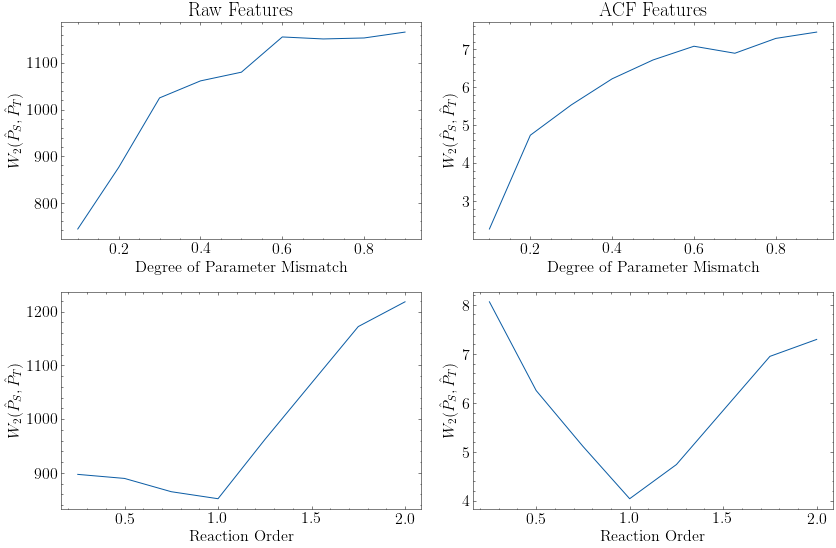

In [82]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 1].plot(EacfX, EacfY)
axes[0, 1].set_ylabel(r'$W_{2}(\hat{P}_{S}, \hat{P}_{T})$')
axes[0, 1].set_xlabel(r'Degree of Parameter Mismatch')
axes[0, 1].set_title('ACF Features')

axes[1, 1].plot(NacfX, NacfY)
axes[1, 1].set_ylabel(r'$W_{2}(\hat{P}_{S}, \hat{P}_{T})$')
axes[1, 1].set_xlabel(r'Reaction Order')

axes[0, 0].plot(ErawX, ErawY)
axes[0, 0].set_ylabel(r'$W_{2}(\hat{P}_{S}, \hat{P}_{T})$')
axes[0, 0].set_xlabel(r'Degree of Parameter Mismatch')
axes[0, 0].set_title('Raw Features')

axes[1, 0].plot(NrawX, NrawY)
axes[1, 0].set_ylabel(r'$W_{2}(\hat{P}_{S}, \hat{P}_{T})$')
axes[1, 0].set_xlabel(r'Reaction Order')

plt.tight_layout()
plt.savefig('./Figures/Ch6/ParametersVSDistributionalShift.pdf')